# Deep Linear Networks

In [1]:
from typing import Optional, Union, List
from dataclasses import dataclass, field
import itertools

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from devinterp.evals import dataloader_reduce, dataloader_map

In [2]:
class DLN(nn.Module):
    """A deep linear network with L layers."""

    def __init__(self, dims: List[int], init_variance: float = 1.0):
        super().__init__()
        self.dims = dims
        self.L = len(dims) - 1
        self.init_variance = init_variance
        self.linears = nn.ModuleList([nn.Linear(d1, d2, bias=False) for d1, d2 in zip(dims[:-1], dims[1:])])

        # Initialize weights and biases
        for l in range(self.L):
            self.linears[l].weight.data.normal_(0, self.init_variance)  # Note: this is not normalized by the input dimension

    def forward(self, x):
        for l in range(self.L):
            x = self.linears[l](x)
        return x
    
    def __repr__(self):
        return f"DLN({self.dims})"
    
    @classmethod
    def make_rectangular(cls, input_dim: int, output_dim: int, L: int, w: int, gamma: float):
        """Make a rectangular DLN with L layers and width w."""
        init_variance = w ** (-gamma)
        return cls([input_dim] + [w] * (L-1) + [output_dim], init_variance=init_variance)
    
    def to_matrix(self):
        """Return the matrix representation of the DLN."""
        return self.forward(torch.eye(self.dims[0]))

    @classmethod
    def from_matrix(cls, A):
        """Construct a DLN from a matrix."""
        dims = [A.shape[0], A.shape[1]]
        dln = cls(dims)
        dln.linears[0].weight.data = A

        return dln
    
    def rank(self):
        """Return the rank of the DLN."""
        return torch.linalg.matrix_rank(self.to_matrix())
    
    def norm(self, p: Union[int, float, str]=2):
        """Return the nuclear norm of the DLN."""
        return torch.norm(self.to_matrix(), p=p)
    
    def grad_norm(self, p=2):
        """Return the norm of the gradient of the DLN."""
        grad_norm = torch.zeros(1)

        if p != 2:
            raise NotImplementedError("Only p=2 is implemented.")

        for l in range(self.L):
            grad_norm += torch.sum(self.linears[l].weight.grad ** p)
            
        return grad_norm ** (1/p)


In [3]:
# Attempt to reproduce Figure 1 of Jacot et al.
np.random.seed(42)

A_true = torch.Tensor(np.random.randn(10, 3) @ np.random.randn(3, 10))

def matrix_completion_loss(A1: torch.Tensor, A2: torch.Tensor, indices: Union[torch.Tensor, np.ndarray]):
    """
    Weird loss that Jacot et al. used. I couldn't get this to work, so ignore it. 
    $\frac{1}{N} \sum_{i=1}^N\left(A_{k_i, m_i}-A_{k_i, m_i}^*\right)^2$ for some true matrix $A^*$ of which we observe only the $N$ entries $A_{k_1, m_1}^*, \ldots, A_{k_N, m_N}^*$.
    """    
    return torch.mean((A1[indices[:, 0], indices[:, 1]] - A2[indices[:, 0], indices[:, 1]])**2)

def train_test_split(indices, test_size=0.2, random_state=None):
    """Split indices into train and test set."""
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.random.permutation(indices)
    split_index = int((1 - test_size) * len(indices))
    return (indices[:split_index]), (indices[split_index:])

all_indices = np.array([(i, j) for i in range(10) for j in range(10)])
train_indices, test_indices = train_test_split(all_indices, test_size=0.8, random_state=42)

def _train_loss(A):
    #A_true_with_noise = torch.Tensor(np.random.randn(10, 10) * 0.2) + A_true
    # return matrix_completion_loss(A, A_true_with_noise, train_indices)
    return matrix_completion_loss(A, A_true, train_indices)

def _test_loss(A):
    return matrix_completion_loss(A, A_true, test_indices)

model = DLN.make_rectangular(10, 10, 4, 100, 2.)
optim = torch.optim.SGD(model.parameters(), lr=1e-4) #, weight_decay=1e-4, momentum=0.9)

train_losses = []
test_losses = []

model.train()

# for i in tqdm(range(10_000), desc="Fitting..."):
#     optim.zero_grad()
#     loss = _train_loss(model.to_matrix())
#     loss.backward()
#     optim.step()

#     train_losses.append(loss.item())

#     with torch.no_grad():
#         test_losses.append(_test_loss(model.to_matrix()))

# plt.plot(train_losses, label='train')
# plt.plot(test_losses, label='test')
# plt.legend()
    

DLN([10, 100, 100, 100, 10])

In [8]:
# From https://github.com/edmundlth/scalable_learning_coefficient_with_sgld/blob/v1.0/experiment.py

from copy import deepcopy
from typing import Any, Type 
from devinterp.slt.sgld import SGLD

def individual_losses(model, dataloader):
    return dataloader_map(model, dataloader, {"mse": lambda m, x, y, yhat: torch.mean((y-yhat)**2, axis=1)})["mse"]

@dataclass
class SGLDChain:
    runs: List[np.ndarray]
    

@dataclass
class SGLDRun:
    chains: SGLDChain
    local_free_energy: float
    lambda_hat: float
    nu_hat: float


class Ensemble(nn.Module):
    """
    A class which contains copies of the same model for estimating quantities 
    like the local free energy, RLCTs, and singular fluctations.    

    This can be used as a drop-in replacement for a nn.Module.

    To be used in conjunction with an optimizer like SGLD.
    """
    def __init__(self, model: nn.Module, num_chains=1):
        super().__init__()
        self.model = model
        self.models = nn.ModuleList([model] + [deepcopy(model) for _ in range(num_chains-1)])
        self.num_chains = num_chains

    @classmethod
    def from_cls(cls, model_cls: Type[nn.Module], *args, num_chains=1, **kwargs):
        model = model_cls(*args, **kwargs)
        return cls(model, num_chains=num_chains)
        
    def forward(self, inputs):
        return [model(inputs) for model in self.models]
    
    def reset(self):
        """Sets all models to the original model's parameters"""
        original_params = self.model.state_dict()

        for model in self.models:
            model.load_state_dict(original_params)

    def average_params_(self):
        """Averages the parameters of all models"""
        params = [model.state_dict() for model in self.models]
        avg_params = params[0]

        for key in avg_params.keys():
            for i in range(1, len(params)):
                avg_params[key] += params[i][key]

            avg_params[key] /= len(params)

    def __len__(self):
        return len(self.models)

    def __iter__(self):
        return iter(self.models)

def estimate_rlct(
    ensemble, trainloader, num_iter=100, elasticity=1., lr=1e-5, verbose=True, **kwargs
):
    if verbose:
        print(f"Estimating RLCT with {ensemble.num_chains} chains, {num_iter} iterations, elasticity={elasticity}, lr={lr}")

    num_training_samples = len(trainloader.dataset)
    optimizer = SGLD(
        ensemble.parameters(), 
        lr=lr, 
        elasticity=elasticity, 
        temperature=torch.log(torch.tensor(num_training_samples)) / num_training_samples,
        **kwargs
    )

    ensemble.train()
    ensemble.zero_grad()
    chain_Lms = [[] for _ in range(ensemble.num_chains)]

    for i, (inputs, labels) in zip(range(num_iter), itertools.cycle(trainloader)):
        for j, model in enumerate(ensemble):
            outputs = model(inputs)
            loss = F.mse_loss(outputs, labels)
            loss.backward(retain_graph=True)
            chain_Lms[j].append(loss.item())
        
        optimizer.step()
        optimizer.zero_grad()

    energy = chain_Lms[0][0] * num_training_samples
    chain_Lms = np.array(chain_Lms)
    local_free_energy = num_training_samples * np.mean(chain_Lms)
    chain_std = np.std(num_training_samples * np.mean(chain_Lms, axis=1))        

    hat_lambda = (local_free_energy - energy) / np.log(num_training_samples)

    if verbose:
        print(
            f"LFE: {local_free_energy} (std: {chain_std}, hat_lambda={hat_lambda}, energy={energy})"
        )
    
    return hat_lambda

# def estimate_rlct(
#     model, trainloader, num_iter=100, num_chains=1, elasticity=1., lr=1e-5, verbose=True, **kwargs
# ):
#     if verbose:
#         print(f"Estimating RLCT with {num_chains} chains, {num_iter} iterations, elasticity={elasticity}, lr={lr}")

#     num_training_samples = len(trainloader.dataset)

#     loss_sum = np.zeros(num_training_samples)
#     loss_sum_sq = np.zeros(num_training_samples)
#     # energy = 0

#     chain_Lms = []
#     model.zero_grad()

#     for chain in range(num_chains):
#         model_copy = deepcopy(model)
#         model_copy.train()

#         optimizer = SGLD(
#             model_copy.parameters(), 
#             lr=lr, 
#             elasticity=elasticity, 
#             temperature = torch.log(torch.tensor(num_training_samples)) / num_training_samples,
#             **kwargs
#         )
#         og_params = deepcopy(dict(model_copy.named_parameters()))
#         Lms = []

#         for i, (inputs, labels) in zip(range(num_iter), itertools.cycle(trainloader)):
#                 # with torch.no_grad():
#                 #     losses = individual_losses(model_copy, trainloader).detach().numpy()
#                 #     loss_sum += losses
#                 #     loss_sum_sq += losses * losses
#                 #     _energy = np.sum(losses)
#                 #     energy = _energy
#                 # elif _energy < energy:
#                 #     energy = _energy
                
#             outputs = model_copy(inputs)
#             loss_ = F.mse_loss(outputs, labels) 
#             loss_.backward(retain_graph=True)
#             optimizer.step()
#             optimizer.zero_grad()

#             Lms.append(loss_.item())
            
#         chain_Lms.append(Lms)
        
#         if verbose:
#             print(f"Chain {chain + 1}: L_m = {np.mean(Lms)}")

#     energy = chain_Lms[0][0] * num_training_samples
#     chain_Lms = np.array(chain_Lms)
#     local_free_energy = num_training_samples * np.mean(chain_Lms)
#     chain_std = np.std(num_training_samples * np.mean(chain_Lms, axis=1))        

#     # variance = (loss_sum_sq - loss_sum * loss_sum / m) / (m - 1)
#     # func_var = float(np.sum(variance))
#     hat_lambda = (local_free_energy - energy) / np.log(num_training_samples)
    
#     if verbose:
#         print(
#             f"LFE: {local_free_energy} (std: {chain_std}, n_chain={num_chains}, hat_lambda={hat_lambda}, energy={energy})"
#         )

#     return hat_lambda

In [23]:
@dataclass
class Run:
    gamma: float = 1.
    w: int = 100
    L: int = 4
    input_dim: int = 5
    output_dim: int = 5
    seed: int = 0
    num_steps: int = 50_000
    lr: float = 1e-4
    student: Optional[DLN] = None
    train_errors: Optional[np.ndarray] = None
    test_errors: Optional[np.ndarray] = None
    ranks: Optional[np.ndarray] = None
    nuc_norms: Optional[np.ndarray] = None
    grad_norms: Optional[np.ndarray] = None

teacher_matrix = torch.Tensor(10 * np.diag(np.arange(1, 6)))
teacher = DLN.from_matrix(teacher_matrix)

def gen_data(num_samples: int, num_features: int):
    inputs = torch.rand(num_samples, num_features)
    labels = teacher(inputs)
    return torch.utils.data.TensorDataset(inputs, labels)

train_data = gen_data(100, 5)
test_data = gen_data(100, 5)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

def effective_rank(model: DLN):
    # Divide the first singular value by the first singular value of the teacher, and so on, then sum.
    # This is the effective rank of the model.
    singular_values = model.to_matrix().svd().S
    teacher_singular_values = teacher_matrix.svd().S

    return (singular_values / teacher_singular_values).sum()

def fit(train_loader, num_chains=5, **kwargs) -> Run:
    train_data = train_loader.dataset
    run = Run(**kwargs)

    if run.student is None:
        run.student = DLN.make_rectangular(run.input_dim, run.output_dim, w=run.w, L=run.L, gamma=run.gamma)

    student = run.student
    optim = torch.optim.SGD(student.parameters(), lr=run.lr, momentum=0.8, weight_decay=1e-4)

    train_errors = []
    test_errors = []
    ranks = []
    nuc_norms = []
    grad_norms = []
    rlcts = []
    eff_ranks = []

    ensemble = Ensemble(student, num_chains=num_chains)

    for i in tqdm(range(run.num_steps), desc="Training"):
        optim.zero_grad()
        loss = F.mse_loss(student(train_data.tensors[0]), train_data.tensors[1])
        loss.backward(retain_graph=True)
        optim.step()

        # if i % 100 == 0 or i < 2000:
        train_errors.append(loss.detach().numpy())
        # ranks.append(student.rank().detach().numpy())   
        # nuc_norms.append(student.norm(p="nuc").detach().numpy())
        grad_norms.append(student.grad_norm().detach().numpy())

        if i % 100 == 0:
            ensemble.reset()
            rlcts.append(estimate_rlct(ensemble, train_loader, verbose=False, num_iter=200, elasticity=1., noise_level=1.))
            eff_ranks.append(effective_rank(student).detach().numpy())

        # with torch.no_grad():
        #     test_errors.append(F.mse_loss(student(test_data.tensors[0]), test_data.tensors[1]).detach().numpy())

    run.train_errors = np.array(train_errors)
    run.test_errors = np.array(test_errors)
    run.ranks = np.array(ranks)
    run.nuc_norms = np.array(nuc_norms)
    run.grad_norms = np.array(grad_norms)
    run.rlcts = np.array(rlcts)
    run.eff_ranks = np.array(eff_ranks)

    return run



In [24]:
def demo_estimate_rlct(
    exponents, num_iter=50, num_chains=1, gamma=1., epsilon=1e-3, verbose=True, num_training_samples=1000
):
    if verbose:
        print(f"Estimating RLCT with {num_chains} chains, {num_iter} iterations, gamma={gamma}, epsilon={epsilon}")

    energy = 0

    chain_Lms = []

    num_weights = len(exponents)
    inputs = torch.randn((num_training_samples, 1))
    outputs = torch.randn((num_training_samples)) / 4.  # True weights are 0

    trainloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(inputs, outputs), batch_size=num_training_samples, shuffle=True
    )

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.weights = nn.Parameter(torch.rand(num_weights, 1))

            for param in self.parameters():
                # param.data = torch.zeros_like(param.data)
                # Uniform initialization
                param.data = torch.rand_like(param.data)

        def forward(self, x):
            return (self.weights ** exponents).prod() * x

    model = Model()

    return estimate_rlct(model, trainloader, num_iter, num_chains, gamma, epsilon, verbose)

for (num_iter, num_training_samples) in itertools.product((10, 100), (100, 1000)):
    torch.manual_seed(0)
    np.random.seed(0)
    print("=" * 80)
    print("num_iter", num_iter, "n", num_training_samples, "\n\n")
    print("0.17", demo_estimate_rlct(torch.Tensor([1, 3]), num_iter=num_iter, num_training_samples=num_training_samples), "\n\n")
    print("0.25", demo_estimate_rlct(torch.Tensor([1, 2]), num_iter=num_iter, num_training_samples=num_training_samples), "\n\n")
    print("0.5", demo_estimate_rlct(torch.Tensor([0, 1]), num_iter=num_iter, num_training_samples=num_training_samples), "\n\n")
    print("0.5", demo_estimate_rlct(torch.Tensor([1, 0]), num_iter=num_iter, num_training_samples=num_training_samples), "\n\n")

num_iter 10 n 100 


Estimating RLCT with 1 chains, 10 iterations, gamma=1.0, epsilon=0.001


TypeError: estimate_rlct() takes from 2 to 6 positional arguments but 7 were given

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

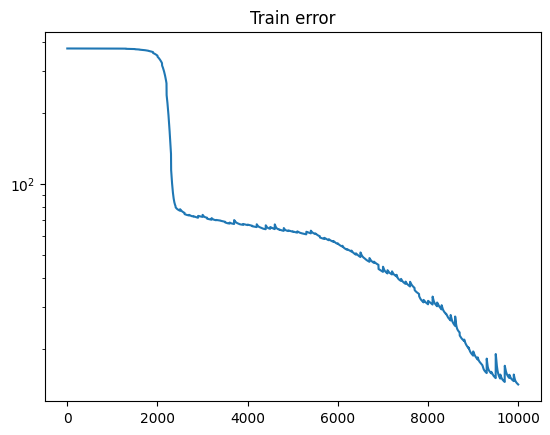

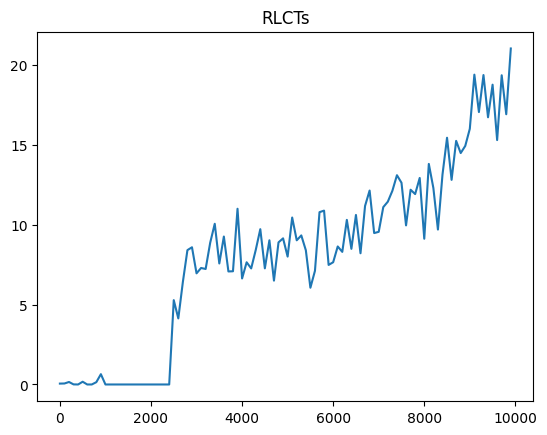

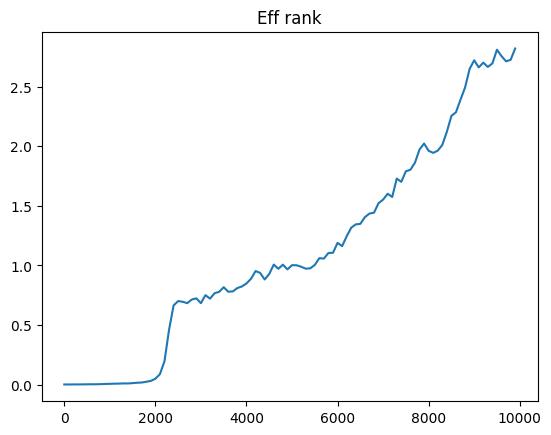

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

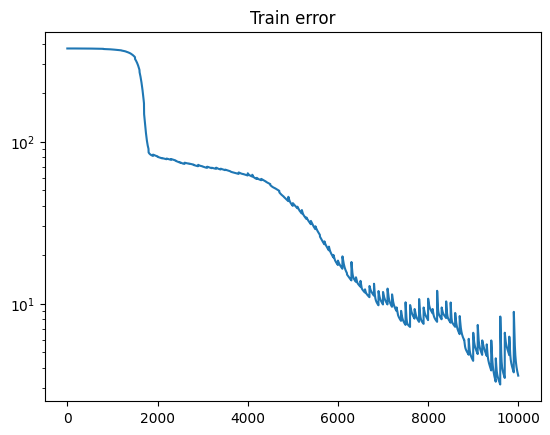

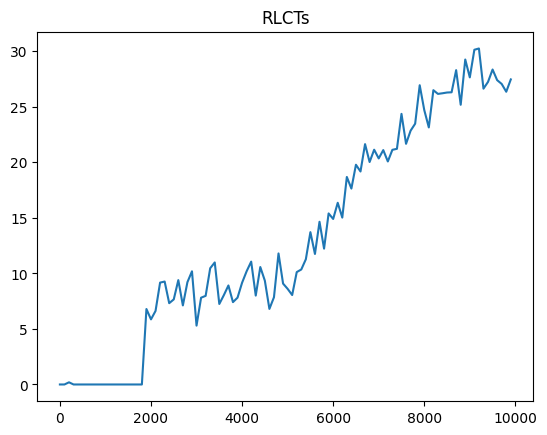

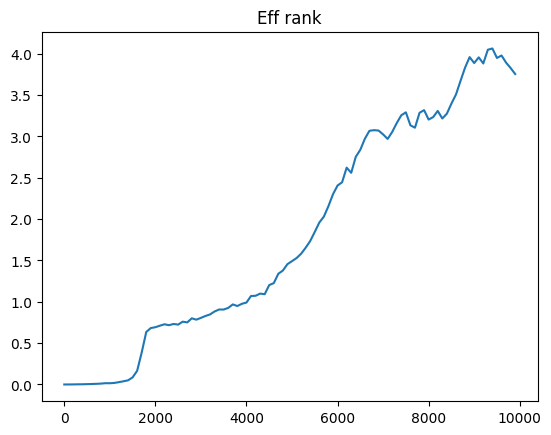

In [25]:

def plot_all(run: Run):
    n_steps = 10_000

    plt.title("Train error")
    plt.plot(np.arange(n_steps), run.train_errors, label="Train")
    plt.yscale("log")
    plt.show()

    # clip to positive values
    rlcts = np.clip(run.rlcts, 0, None)
    # rlcts = sample_run.rlcts

    plt.title("RLCTs")
    plt.plot(np.arange(0, n_steps, 100), rlcts, label="RLCT")
    # plt.yscale("log")
    plt.show()

    plt.title("Eff rank")
    plt.plot(np.arange(0, n_steps, 100), run.eff_ranks, label="Eff. rank")
    # plt.yscale("log")
    plt.show()

    # plt.title("Nuclear norms")
    # plt.plot(np.arange(n_steps), sample_run.nuc_norms, label="Nuc norms")
    # # plt.yscale("log")
    # plt.show()


torch.manual_seed(1)
np.random.seed(1)

lr = 1e-5

w10_run = fit(train_loader, num_steps=10_000, w=10, L=4, gamma=1.1, lr=lr, num_chains=50)
plot_all(w10_run)

w20_run = fit(train_loader, num_steps=10_000, w=20, L=4, gamma=1.1, lr=lr, num_chains=50)
plot_all(w20_run)

# w50_run = fit(train_loader, num_steps=10_000, w=50, L=4, gamma=1.1, lr=lr)
# plot_all(w50_run)

# w100_run = fit(train_loader, num_steps=10_000, w=50, L=4, gamma=1.1, lr=lr)
# plot_all(w100_run)

In [26]:
@dataclass
class Runs:
    runs: List[Run] = field(default_factory=list)

    def filter(self, **kwargs):
        return Runs([run for run in self.runs if self.matches(run, **kwargs)])

    @staticmethod
    def matches(run, **kwargs):
        return all([getattr(run, k) == v for k, v in kwargs.items()])
    
    def __iter__(self):
        return iter(self.runs)
    
    def __len__(self):
        return len(self.runs)
    
    def __getitem__(self, i):
        return self.runs[i]
    
    def __repr__(self):
        return f"Runs({self.runs})"
    
    def __add__(self, other):
        return Runs(self.runs + other.runs)
    
    def __iadd__(self, other):
        self.runs += other.runs
        return self
    
    def append(self, run):
        self.runs.append(run)

runs = Runs()


# Define a unique set of gammas
gammas = [0.75, 1., 1.5]
ws = [10, 100]

for gamma, w in tqdm(list(itertools.product(gammas, ws)), desc="Sweeping"):
    runs.append(fit(train_loader, gamma=gamma, w=w))


Sweeping:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix contained non-finite values.

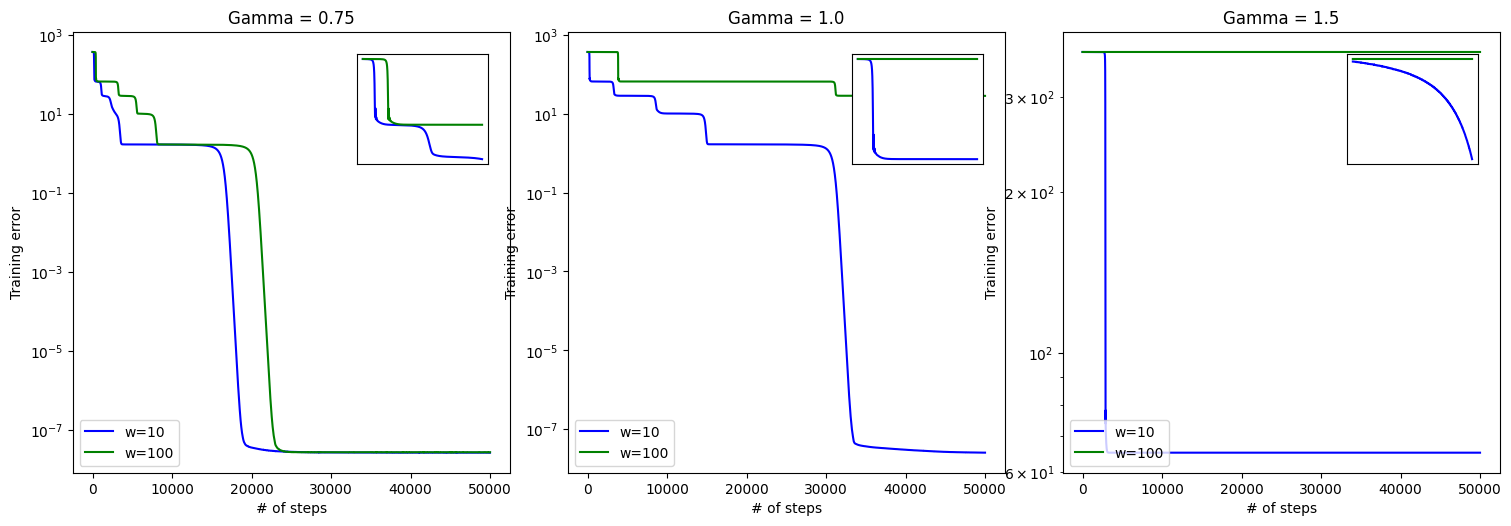

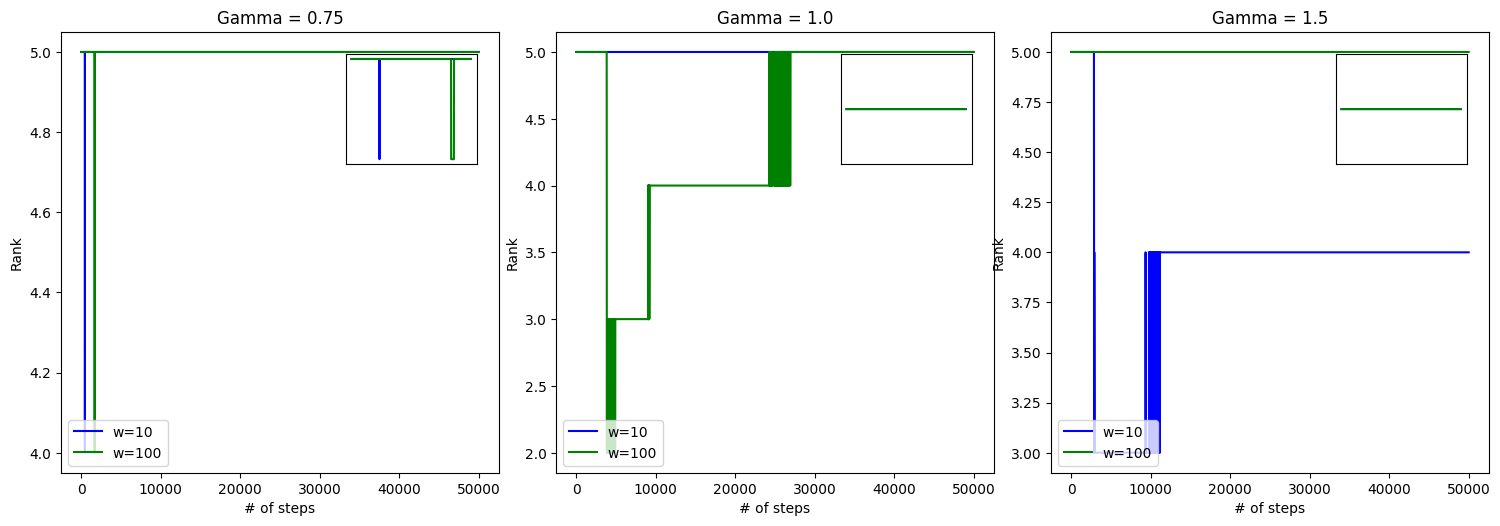

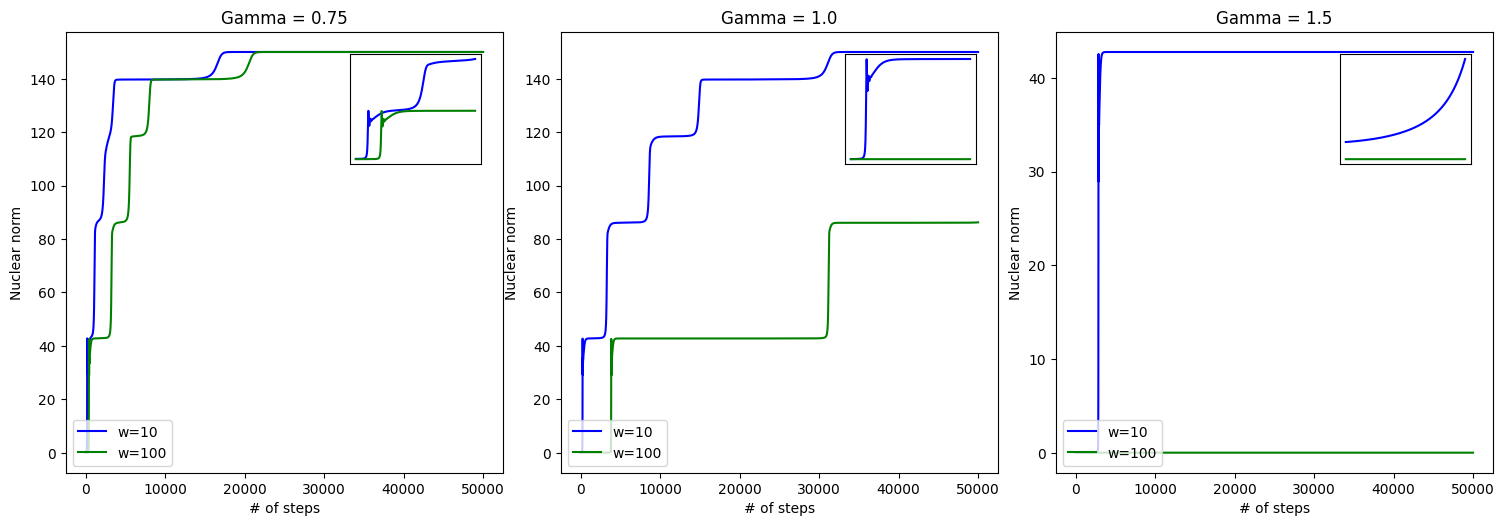

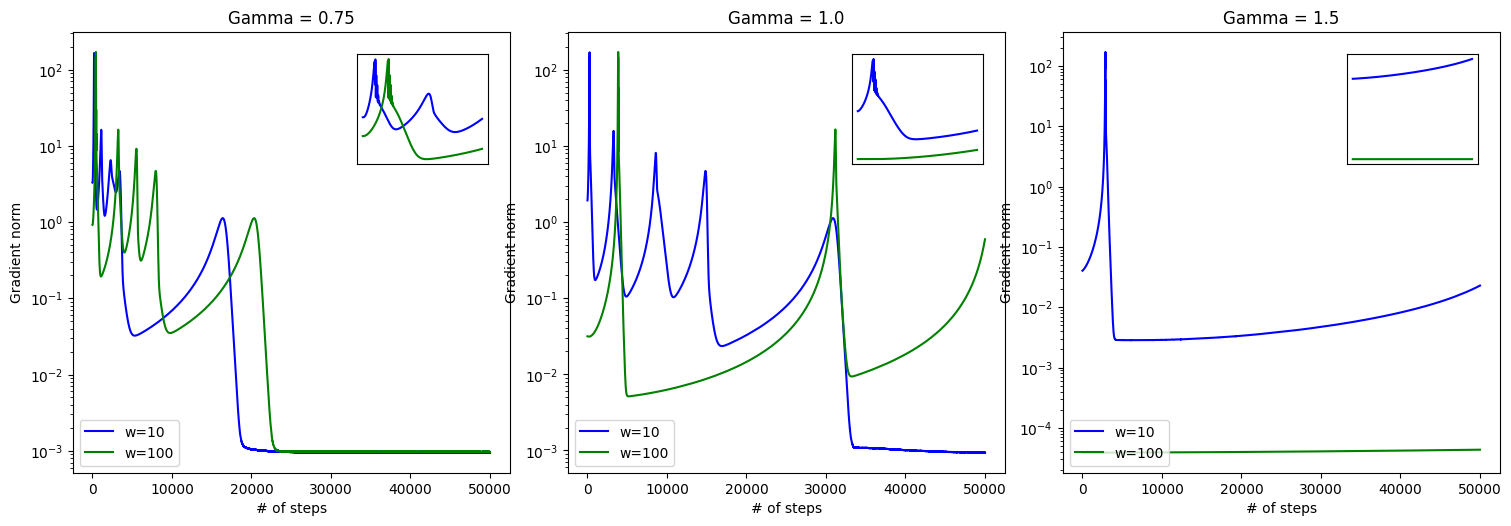

In [17]:
import matplotlib.pyplot as plt

def plot(runs: Runs, metric: str, ylabel: str, title: str, logscale: bool = False):

    # Define the colors for each w value
    colors = {10: 'b', 100: 'g'}

    # Create a figure with 3 subplots (one for each gamma)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    fig.tight_layout()


    # Iterate through the unique gammas
    for i, gamma in enumerate(gammas):
        ax = axes[i]
        # Add an inset focusing on the first 2000 steps
        ax_inset = ax.inset_axes([0.65, 0.7, 0.3, 0.25])

        # Iterate through the runs, filtering by the current gamma
        for run in runs.filter(gamma=gamma):
            values = getattr(run, metric)
            w = run.w
            color = colors[w]
            
            # Plot the training error against the number of steps
            ax.plot(values, color=color, label=f'w={w}')
            ax_inset.plot(values[:2000], color=color)
        
        ax_inset.yaxis.set_visible(False)
        ax_inset.xaxis.set_visible(False)
        ax.set_xlabel('# of steps')
        ax.set_ylabel(ylabel)
        
        if logscale:
            ax_inset.set_yscale('log')
            ax.set_yscale('log')

        ax.set_title(f'Gamma = {gamma}')
        ax.legend(loc='lower left') 

    plt.show()

plot(runs, 'train_errors', 'Training error', 'Training error', logscale=True)
# plot(runs, 'test_errors', 'Test error', 'Test error', logscale=True)
plot(runs, 'ranks', 'Rank', 'Rank', logscale=False)
plot(runs, 'nuc_norms', 'Nuclear norm', 'Nuclear norm', logscale=False)
plot(runs, 'grad_norms', 'Gradient norm', 'Gradient norm', logscale=True)

In [ ]:
# From https://github.com/edmundlth/scalable_learning_coefficient_with_sgld/blob/v1.0/experiment.py

from copy import deepcopy

def individual_losses(model, dataloader):
    return dataloader_map(model, dataloader, {"mse": lambda m, x, y, yhat: torch.mean((y-yhat)**2, axis=1)})["mse"]

@dataclass
class SGLDChain:
    runs: List[np.ndarray]
    

@dataclass
class SGLDRun:
    chains: SGLDChain
    local_free_energy: float
    lambda_hat: float
    nu_hat: float


# class SGLD(nn.optim.Optimizer):
#     def __init__(self, params, lr=1e-3, gamma=1e-4, noise=1e-3):
#         defaults = dict(lr=lr, gamma=gamma, noise=noise)
#         self.step = 0
#         super(SGLD, self).__init__(params, defaults)

#     def step(self, closure=None):
#         loss = None
#         if closure is not None:
#             loss = closure()

#         for group in self.param_groups:
#             gamma = group["gamma"]
#             noise = group["noise"]
#             for p in group["params"]:
#                 if p.grad is None:
#                     continue
#                 d_p = p.grad.data
#                 if gamma != 0:
#                     p.data.add_(d_p, alpha=-group["lr"])
#                 if noise != 0:
#                     p.data.add_(torch.randn_like(p.data) * np.sqrt(noise * 2 * group["lr"]), alpha=1)

#         return loss


def estimate_rlct(
    model, trainloader, num_iter=100, num_chains=1, gamma=None, epsilon=1e-5, verbose=True
):
    num_training_samples = len(trainloader.dataset)
    gamma_dict = {}
    
    if gamma is None:
        with torch.no_grad():
            for name, param in model.named_parameters():
                gamma_val = 100.0 / np.linalg.norm(param)
                gamma_dict[name] = gamma_val

    loss_sum = np.zeros(num_training_samples)
    loss_sum_sq = np.zeros(num_training_samples)
    energy = 0

    chain_Lms = []
    model.zero_grad()

    for chain in range(num_chains):
        model_copy = deepcopy(model)
        model_copy.train()
        og_params = deepcopy(dict(model_copy.named_parameters()))
        Lms = []

        for i, (inputs, labels) in zip(range(num_iter), itertools.cycle(trainloader)):
            with torch.no_grad():
                losses = individual_losses(model_copy, trainloader).detach().numpy()
                loss_sum += losses
                loss_sum_sq += losses * losses

                if i == 0:
                    energy = np.sum(losses)
                
            # call a minibatch loss backward
            # so that we have gradient of average minibatch loss with respect to w'

            outputs = model_copy(inputs)
            loss_ = F.mse_loss(outputs, labels)
            loss_.backward(retain_graph=True)

            # TODO: Put this in an optimizer
            for name, w in model_copy.named_parameters():
                w_og = og_params[name]
                dw = -w.grad.data / np.log(num_training_samples) * num_training_samples

                if gamma is None:
                    prior_weight = gamma_dict[name]
                else:
                    prior_weight = gamma

                dw.add_(w.data - w_og.data, alpha=-prior_weight)
                w.data.add_(dw, alpha=epsilon / 2)
                gaussian_noise = torch.empty_like(w)
                gaussian_noise.normal_()
                w.data.add_(gaussian_noise, alpha=np.sqrt(epsilon))
                w.grad.zero_()

            Lms.append(loss_.item())
        chain_Lms.append(Lms)
        
        if verbose:
            print(f"Chain {chain + 1}: L_m = {np.mean(Lms)}")

    chain_Lms = np.array(chain_Lms)
    local_free_energy = num_training_samples * np.mean(chain_Lms)
    chain_std = np.std(num_training_samples * np.mean(chain_Lms, axis=1))        

    # variance = (loss_sum_sq - loss_sum * loss_sum / m) / (m - 1)
    # func_var = float(np.sum(variance))
    hat_lambda = (local_free_energy - energy) / np.log(num_training_samples)
    
    if verbose:
        print(
            f"LFE: {local_free_energy} (std: {chain_std}, n_chain={num_chains}, hat_lambda={hat_lambda}, energy={energy})"
        )

    return hat_lambda

[2.5, 6.5, 12.5, 18.5, 24.5, 30.5]
